# Проект: Прогнозирование заказов такси

**Описание проекта**

В компании «Чётенькое такси» (название вымышленное) решили оптимизировать работу сервиса в аэропортах и собрали для этого исторические данные о заказах такси по аэропортам. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Моя задача: построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

*Примечание:* Проект выполнен на английском языке.

<h1>Table of contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-of-data" data-toc-modified-id="Prepare-of-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare of data</a></span><ul class="toc-item"><li><span><a href="#Import-of-libraries" data-toc-modified-id="Import-of-libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import of libraries</a></span></li><li><span><a href="#Open-the-data" data-toc-modified-id="Open-the-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Open the data</a></span></li></ul></li><li><span><a href="#Analisys" data-toc-modified-id="Analisys-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analisys</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Prepare-of-data" data-toc-modified-id="Prepare-of-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare of data</a></span></li><li><span><a href="#Train-models" data-toc-modified-id="Train-models-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train models</a></span></li></ul></li><li><span><a href="#Test" data-toc-modified-id="Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Final-result" data-toc-modified-id="Final-result-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final result</a></span></li></ul></div>

## Prepare of data

### Import of libraries

In first import the libraries we are need:

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

### Open the data

Now we will open the data and let's see the information:

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
print('Data:')
display(df)
print('-------------------------------------')
print()
print('Info:')
print(df.info())

Data:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


-------------------------------------

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


We have two columns. The first column is a date in object format and the second column is number of orders. Let's reopen our dataset. We need to take date column as index.

In [3]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print('Data:')
display(df)
print('-------------------------------------')
print()
print('Info:')
print(df.info())

Data:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


-------------------------------------

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None


We took the data in the format we need.

## Analisys

Now let's check the index is monotone:

In [4]:
print(df.index.is_monotonic)

True


Ok. Next, we need to check the "num_orders" column for outliers:

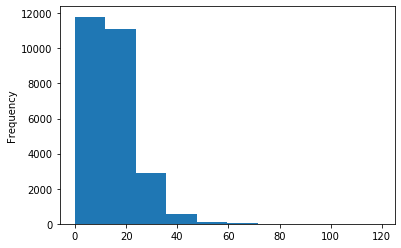

In [5]:
df['num_orders'].plot(kind='hist')

In [6]:
df[df['num_orders'] > 60]

,num_orders
datetime,
2018-04-24 00:30:00,68
2018-07-16 04:40:00,64
2018-07-19 10:50:00,61
2018-08-08 00:50:00,64
2018-08-08 01:00:00,64
2018-08-11 00:50:00,64
2018-08-11 01:00:00,62
2018-08-13 01:00:00,64
2018-08-13 01:10:00,71


We have one-way distribution with long tail. Maybe sometimes taxi service really have too much orders. I think it's normal.

Maybe sometimes we have some zero values, let's look on it:

In [7]:
df[df['num_orders'] == 0].sample(20)

,num_orders
datetime,
2018-03-09 04:50:00,0
2018-07-14 07:10:00,0
2018-04-03 07:20:00,0
2018-04-10 06:40:00,0
2018-04-03 05:40:00,0
2018-03-05 03:00:00,0
2018-03-08 06:10:00,0
2018-04-25 06:20:00,0
2018-03-22 06:00:00,0


As we can see, sometimes there are really no orders in the taxi service early at the morning.

Now let's see the seasonal and trend in orders. We can try resample our data to 1 day format:

In [8]:
df_daily = round(df.resample('1D').sum()).astype('int')
df_daily

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
...,...
2018-08-27,3936
2018-08-28,3357
2018-08-29,3762


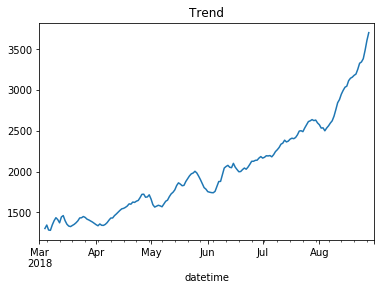

In [9]:
decomposed_daily = seasonal_decompose(df_daily['num_orders'])
decomposed_daily.trend.plot(title='Trend')

We see the uptrend from spring to autumn. I think it because in summer starts the season of vacations and more people using flight services.

Now let's add the day of week column and see the seasonal of orders in july for example:

In [10]:
df_daily['dayofweek'] = df_daily.index.dayofweek
df_daily.head()

,num_orders,dayofweek
datetime,,
2018-03-01,1364,3
2018-03-02,1506,4
2018-03-03,1290,5
2018-03-04,1141,6
2018-03-05,1259,0


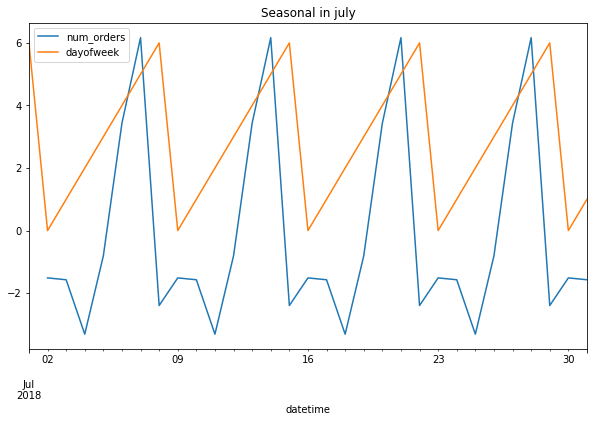

In [11]:
df_daily_july = df_daily['2018-07':'2018-07']
decomposed_daily_july = seasonal_decompose(df_daily_july['num_orders'])
((decomposed_daily_july.seasonal.rolling(2).mean()) * .05).plot(figsize=(10,6), title='Seasonal in july', legend=True)
df_daily_july['dayofweek'].plot(legend=True)

Here we see cycles of increasing the amount of orders by the end of a week and decreasing at the beginning of a week.

Next let's see how number of orders changes depending on the time of day.

In [12]:
df_hourly = round(df.resample('1H').sum()).astype('int')
df_hourly

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


We will get three days in july:

In [13]:
df_hourly_in_week = df_hourly['2018-07-05':'2018-07-07']

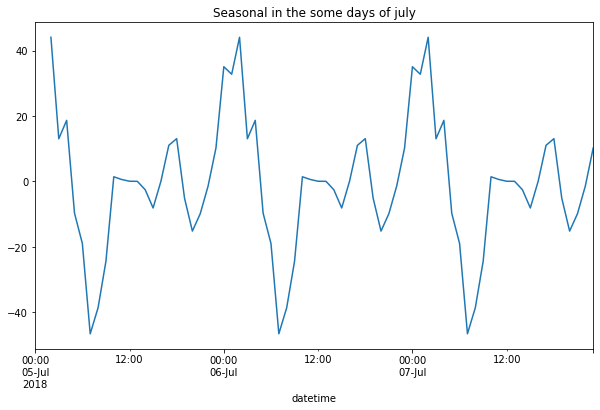

In [14]:
decomposed_hourly_in_week = seasonal_decompose(df_hourly_in_week['num_orders'])
decomposed_hourly_in_week.seasonal.rolling(3).mean().plot(figsize=(10,6), title='Seasonal in the some days of july')


We again see cycles with the maximum of orders at night at the end of one day and at the beginning of a new day. And minimum of orders at the morning of each day.

As a result we see some regularities like increase number of orders to the end of a week and the end of a day. It may help as to make time lag in the data for better result in train our models.

## Train

### Prepare of data

Let's get table with hourly indexes, because we need predictions for hour intervals. We need to create columns with: date features, 6-hour rolling mean, and 6-, 12- and 24-hour time-lag.

In [15]:
df_hourly['month'] = df_hourly.index.month
df_hourly['day'] = df_hourly.index.day
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek

df_hourly['rolling_mean'] = round(df_hourly['num_orders'].shift().rolling(6).mean())

df_hourly['lag_6'] = df_hourly['num_orders'].shift(6)
df_hourly['lag_12'] = df_hourly['num_orders'].shift(12)
df_hourly['lag_24'] = df_hourly['num_orders'].shift(24)

df_hourly.dropna(inplace=True)
df_hourly.head()

,num_orders,month,day,hour,day_of_week,rolling_mean,lag_6,lag_12,lag_24
datetime,,,,,,,,,
2018-03-02 00:00:00,90,3,2,0,4,69.0,73.0,30.0,124.0
2018-03-02 01:00:00,120,3,2,1,4,72.0,45.0,32.0,85.0
2018-03-02 02:00:00,75,3,2,2,4,85.0,61.0,48.0,71.0
2018-03-02 03:00:00,64,3,2,3,4,87.0,66.0,66.0,66.0
2018-03-02 04:00:00,20,3,2,4,4,87.0,113.0,43.0,43.0


Let's take a look at the correlations between features:

In [16]:
df_hourly.corr()

,num_orders,month,day,hour,day_of_week,rolling_mean,lag_6,lag_12,lag_24
num_orders,1.000000,0.509279,1.612854e-01,4.184469e-03,-1.967969e-02,0.483771,0.237952,0.332320,0.691576
month,0.509279,1.000000,-8.068001e-03,0.000000e+00,-1.205490e-02,0.694339,0.507195,0.505717,0.504805
day,0.161285,-0.008068,1.000000e+00,4.244517e-19,-1.395908e-02,0.219627,0.160896,0.164301,0.156231
hour,0.004184,0.000000,4.244517e-19,1.000000e+00,2.359517e-17,-0.157290,-0.072605,-0.079828,0.004107
day_of_week,-0.019680,-0.012055,-1.395908e-02,2.359517e-17,1.000000e+00,-0.038809,-0.026970,-0.039358,0.030720
rolling_mean,0.483771,0.694339,2.196266e-01,-1.572905e-01,-3.880903e-02,1.000000,0.655296,0.381980,0.419159
lag_6,0.237952,0.507195,1.608962e-01,-7.260523e-02,-2.697046e-02,0.655296,1.000000,0.234173,0.206857
lag_12,0.332320,0.505717,1.643008e-01,-7.982777e-02,-3.935782e-02,0.381980,0.234173,1.000000,0.328305
lag_24,0.691576,0.504805,1.562314e-01,4.106977e-03,3.072031e-02,0.419159,0.206857,0.328305,1.000000


We see higher correlation between target feature and: month, rolling mean and 24-hour lag. Perhaps they will be the most important for train models.

Now let's divide the data into training, validation and test samples in a ratio of 80/10/10:

In [17]:
features = df_hourly.drop('num_orders', axis=1)
target = df_hourly['num_orders']

features, features_test, target, target_test = train_test_split(
    features, target, test_size=.1, shuffle=False)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.1111, shuffle=False)

print('Features', features_train.shape, features_valid.shape, features_test.shape, sep='  |  ')
print('Targets', target_train.shape, target_valid.shape, target_test.shape, sep='   |   ')
print('Ratio',
    round(len(features_train) / len(df_hourly) * 100),
    round(len(features_valid) / len(df_hourly) * 100),
    round(len(features_test) / len(df_hourly) * 100), sep='     |     ')

Features  |  (3512, 8)  |  (440, 8)  |  (440, 8)
Targets   |   (3512,)   |   (440,)   |   (440,)
Ratio     |     80     |     10     |     10


In [18]:
print('|--------------------- Features train --------------------->')
print(features_train.index)
print('---------------------> Features valid --------------------->')
print(features_valid.index)
print('---------------------> Features test ---------------------->')
print(features_test.index)
print('-----------------------------------------------------------|')

|--------------------- Features train --------------------->
DatetimeIndex(['2018-03-02 00:00:00', '2018-03-02 01:00:00',
               '2018-03-02 02:00:00', '2018-03-02 03:00:00',
               '2018-03-02 04:00:00', '2018-03-02 05:00:00',
               '2018-03-02 06:00:00', '2018-03-02 07:00:00',
               '2018-03-02 08:00:00', '2018-03-02 09:00:00',
               ...
               '2018-07-25 22:00:00', '2018-07-25 23:00:00',
               '2018-07-26 00:00:00', '2018-07-26 01:00:00',
               '2018-07-26 02:00:00', '2018-07-26 03:00:00',
               '2018-07-26 04:00:00', '2018-07-26 05:00:00',
               '2018-07-26 06:00:00', '2018-07-26 07:00:00'],
              dtype='datetime64[ns]', name='datetime', length=3512, freq='H')
---------------------> Features valid --------------------->
DatetimeIndex(['2018-07-26 08:00:00', '2018-07-26 09:00:00',
               '2018-07-26 10:00:00', '2018-07-26 11:00:00',
               '2018-07-26 12:00:00', '2018-07-2

The split went well.

### Train models

Let's get models: Decision Tree Regressor, Random Forest Regressor, Linear Regression and Light GBM.

Now we will create function for search the model with best parameteres on train and validation dataset. 

In [19]:
def fit_and_check(model, features_train, target_train,
                  features_valid, target_valid):
    global best_model
    global best_result
    clf = model
    clf.fit(features_train, target_train)
    predictions = clf.predict(features_valid)
    result = (mean_squared_error(target_valid, predictions)) ** .5
    if result < best_result:
        best_result = round(result, 2)
        best_model = model

Now we will train our models and save best of them and save results.

At first - model Decision Tree Regressor:

In [20]:
best_model = 0
best_result = 10000

for depth in range(1, 20):
    fit_and_check(
        DecisionTreeRegressor(max_depth=depth, random_state=555),
        features_train, target_train, features_valid, target_valid)
    
best_tree_model, best_tree_result = best_model, best_result

print(best_tree_model)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=555, splitter='best')


Next - model Random Forest Regressor:

In [21]:
best_model = 0
best_result = 10000

for est in range(10, 100, 10):
    for depth in range(1, 15):
        fit_and_check(
            RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=555),
            features_train, target_train, features_valid, target_valid)
        
best_forest_model, best_forest_result = best_model, best_result

print(best_forest_model)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=90,
                      n_jobs=None, oob_score=False, random_state=555, verbose=0,
                      warm_start=False)


Next - model Linear Regression:

In [22]:
best_model = 0
best_result = 10000

fit_and_check(LinearRegression(), features_train, target_train, features_valid, target_valid)

best_linear_model, best_linear_result = best_model, best_result

print(best_linear_model)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


At last - model Light GBM:

In [23]:
train_data = lgb.Dataset(features_train, target_train)
validation_data = lgb.Dataset(features_valid, target_valid)
params_lgb = {'objective': 'regression', 'metric': 'root_mean_squared_error'}

lgb_tree_model = lgb.train(params_lgb, train_data, num_boost_round=77, valid_sets=(validation_data))
lgb_tree_predictions = lgb_tree_model.predict(features_valid)

lgb_tree_result = round((mean_squared_error(target_valid, lgb_tree_predictions) ** .5), 2)

[1]	valid_0's rmse: 55.6119
[2]	valid_0's rmse: 53.1685
[3]	valid_0's rmse: 50.9823
[4]	valid_0's rmse: 49.1344
[5]	valid_0's rmse: 47.3909
[6]	valid_0's rmse: 45.7462
[7]	valid_0's rmse: 44.3799
[8]	valid_0's rmse: 43.2238
[9]	valid_0's rmse: 42.0837
[10]	valid_0's rmse: 41.1425
[11]	valid_0's rmse: 40.35
[12]	valid_0's rmse: 39.5523
[13]	valid_0's rmse: 39.0003
[14]	valid_0's rmse: 38.3336
[15]	valid_0's rmse: 37.7434
[16]	valid_0's rmse: 37.269
[17]	valid_0's rmse: 36.7655
[18]	valid_0's rmse: 36.3274
[19]	valid_0's rmse: 35.9254
[20]	valid_0's rmse: 35.5938
[21]	valid_0's rmse: 35.2899
[22]	valid_0's rmse: 34.7949
[23]	valid_0's rmse: 34.4175
[24]	valid_0's rmse: 34.0212
[25]	valid_0's rmse: 33.8367
[26]	valid_0's rmse: 33.7214
[27]	valid_0's rmse: 33.4033
[28]	valid_0's rmse: 33.2842
[29]	valid_0's rmse: 32.9978
[30]	valid_0's rmse: 32.8713
[31]	valid_0's rmse: 32.8082
[32]	valid_0's rmse: 32.6315
[33]	valid_0's rmse: 32.5666
[34]	valid_0's rmse: 32.4946
[35]	valid_0's rmse: 32.40

Let's look at the training results:

In [24]:
train_model_results = {
    'RMSE score': [best_tree_result, best_forest_result, best_linear_result, lgb_tree_result]}

train_results = pd.DataFrame(
    data=train_model_results, index=('Model Tree:', 'Model Forest:',
                                     'Linear Model', 'Model LightGBM:'))
train_results

,RMSE score
Model Tree:,34.36
Model Forest:,32.87
Linear Model,37.47
Model LightGBM:,31.59


We see the best results have model Light GBM. But other models have not so badly results.

## Test

Now we will test our best models on test dataset and compare the results.

Let's create the function for refiting best models on datasets without validation splitting, as well as testing and saving results.

In [25]:
def test_model(model, features, target, features_test, target_test):
    model.fit(features, target)
    predictions = model.predict(features_test)
    result = round((mean_squared_error(target_test, predictions) ** .5), 2)
    return result

Let's run a test:

In [26]:
test_tree_result = test_model(best_tree_model, features, target, features_test, target_test)
test_forest_result = test_model(best_forest_model, features, target, features_test, target_test)
test_linear_result = test_model(best_linear_model, features, target, features_test, target_test)

In [27]:
train_data = lgb.Dataset(features, target)
validation_data = lgb.Dataset(features, target)
params_lgb = {'objective': 'regression', 'metric': 'root_mean_squared_error'}

lgb_tree_model = lgb.train(params_lgb, train_data, num_boost_round=77, valid_sets=(validation_data))
lgb_tree_predictions = lgb_tree_model.predict(features_test)

test_lgb_result = round((mean_squared_error(target_test, lgb_tree_predictions) ** .5), 2)

[1]	valid_0's rmse: 36.4079
[2]	valid_0's rmse: 34.4196
[3]	valid_0's rmse: 32.6655
[4]	valid_0's rmse: 31.1896
[5]	valid_0's rmse: 29.8686
[6]	valid_0's rmse: 28.7312
[7]	valid_0's rmse: 27.7432
[8]	valid_0's rmse: 26.8283
[9]	valid_0's rmse: 26.0313
[10]	valid_0's rmse: 25.3808
[11]	valid_0's rmse: 24.7758
[12]	valid_0's rmse: 24.2363
[13]	valid_0's rmse: 23.8153
[14]	valid_0's rmse: 23.3926
[15]	valid_0's rmse: 23.0391
[16]	valid_0's rmse: 22.6775
[17]	valid_0's rmse: 22.35
[18]	valid_0's rmse: 22.0741
[19]	valid_0's rmse: 21.8028
[20]	valid_0's rmse: 21.5307
[21]	valid_0's rmse: 21.3367
[22]	valid_0's rmse: 21.1516
[23]	valid_0's rmse: 20.9351
[24]	valid_0's rmse: 20.7402
[25]	valid_0's rmse: 20.5616
[26]	valid_0's rmse: 20.3354
[27]	valid_0's rmse: 20.1788
[28]	valid_0's rmse: 20.0024
[29]	valid_0's rmse: 19.8973
[30]	valid_0's rmse: 19.7622
[31]	valid_0's rmse: 19.5995
[32]	valid_0's rmse: 19.4705
[33]	valid_0's rmse: 19.3386
[34]	valid_0's rmse: 19.2512
[35]	valid_0's rmse: 19.1

In [28]:
test_model_results = {
    'RMSE score': [test_tree_result, test_forest_result, test_linear_result, test_lgb_result]}
test_results = pd.DataFrame(
    data=test_model_results, index=('Model Tree:', 'Model Forest:',
                                    'Linear Model', 'Model LightGBM:'))
test_results

,RMSE score
Model Tree:,61.70
Model Forest:,42.28
Linear Model,49.85
Model LightGBM:,40.55


As a result, wins model Light GBM. The model Forest has good score too. Linear model and Tree model hasn't scores we need.

Finaly, let's look what kind of features have more important weights for our models. We will take model Random Forest for example.

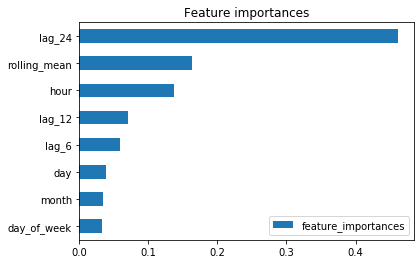

In [29]:
feature_importances = pd.DataFrame(
    best_forest_model.feature_importances_, index=features.columns, columns=['feature_importances'])
feature_importances.sort_values(by=['feature_importances']).plot(kind='barh', title='Feature importances')

As I expected, the more important features were the Lag-24 and the moving average. Unexpectedly, the hour column also turned out to be quite important for the model. The rest of the features are almost equal in importance.

## Final result

As we see only two models have results we need. The best was model Light GBM. The feature 24-hour time lag helps very good for train models, because we realy have 24-hour cicles in number of orders. Apparently at night people often have to use taxi services due to the inaccessibility of other types of transport.

I hope these models and that method of prediction helps taxi service.